In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Airports2.csv')

In [3]:
# Supponiamo che il tuo DataFrame originale sia df
alpha = 0.4  # Peso per il numero di voli
beta = 0.6   # Peso per il numero di passeggeri

# Aggrega i dati per coppia di aeroporti, sommando i voli e i passeggeri
df_agg = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({
    'Flights': 'sum',       # Somma il numero di voli
    'Passengers': 'sum'     # Somma il numero di passeggeri
})

# Calcola il peso combinato per ogni arco
df_agg['Weight'] = alpha * df_agg['Flights'] + beta * df_agg['Passengers']

# Creazione della lista di adiacenza pesata
adj_list_weighted = {}
for index, row in df_agg.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Weight']

    # Aggiungi l'arco nella lista di adiacenza
    if origin not in adj_list_weighted:
        adj_list_weighted[origin] = {}
    if destination not in adj_list_weighted:
        adj_list_weighted[destination] = {}

    # Poiché il grafo è non diretto, aggiungi l'arco in entrambe le direzioni
    adj_list_weighted[origin][destination] = weight
    adj_list_weighted[destination][origin] = weight

# Visualizza la lista di adiacenza pesata
print(f"Numero di nodi: {len(adj_list_weighted)}")
print(f"Numero di archi: {sum(len(neighbors) for neighbors in adj_list_weighted.values()) // 2}")


Numero di nodi: 727
Numero di archi: 23125


In [4]:
# Numero di archi prima dell'aggregazione
# Per ogni coppia Origin_airport e Destination_airport, contiamo come un arco
num_edges_before = len(df)

# Aggregazione per ridurre gli archi
alpha = 0.4  # Peso per il numero di voli
beta = 0.6   # Peso per il numero di passeggeri

# Raggruppamento per coppia di aeroporti
df_agg = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({
    'Flights': 'sum',
    'Passengers': 'sum'
})

# Calcolo del peso combinato
df_agg['Weight'] = alpha * df_agg['Flights'] + beta * df_agg['Passengers']

# Numero di archi dopo l'aggregazione
num_edges_after = len(df_agg)

# Creazione della lista di adiacenza pesata
adj_list_weighted = {}
for index, row in df_agg.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Weight']

    if origin not in adj_list_weighted:
        adj_list_weighted[origin] = {}
    if destination not in adj_list_weighted:
        adj_list_weighted[destination] = {}

    adj_list_weighted[origin][destination] = weight
    adj_list_weighted[destination][origin] = weight

# Output
print(f"Numero di archi prima dell'aggregazione: {num_edges_before}")
print(f"Numero di archi dopo l'aggregazione: {num_edges_after}")
print(f"Riduzione degli archi: {num_edges_before - num_edges_after} ({((num_edges_before - num_edges_after) / num_edges_before) * 100:.2f}%)")


Numero di archi prima dell'aggregazione: 3606803
Numero di archi dopo l'aggregazione: 36719
Riduzione degli archi: 3570084 (98.98%)


In [5]:
df_agg.head()

,Origin_airport,Destination_airport,Flights,Passengers,Weight
0,1B1,BDL,1,1,1.0
1,ABE,ABE,26,2524,1524.8
2,ABE,ACT,1,0,0.4
3,ABE,ACY,1,73,44.2
4,ABE,ADS,1,0,0.4


In [6]:
from collections import defaultdict
import random
import time

def compute_modularity(adj_list, communities, m):
    """Calcola la modularità pesata del grafo."""
    Q = 0.0
    for node in adj_list:
        for neighbor, weight in adj_list[node].items():
            if communities[node] == communities[neighbor]:  # Se sono nella stessa comunità
                ki = sum(adj_list[node].values())  # Grado pesato del nodo
                kj = sum(adj_list[neighbor].values())  # Grado pesato del vicino
                Q += weight - (ki * kj) / (2 * m)
    return Q / (2 * m)

def louvain_with_max_iterations(adj_list, max_iterations=300):
    """Implementazione dell'algoritmo Louvain con un massimo di iterazioni."""
    # Inizializza ogni nodo in una comunità separata
    communities = {node: i for i, node in enumerate(adj_list)}
    m = sum(sum(neighbors.values()) for neighbors in adj_list.values()) / 2  # Somma totale dei pesi

    print(f"Numero totale di nodi: {len(adj_list)}, Peso totale del grafo (2m): {2 * m}")

    improvement = True
    iteration = 0
    modularity_history = []  # Storico della modularità per monitorare i miglioramenti

    while iteration < max_iterations:
        iteration += 1
        improvement = False
        nodes = list(adj_list.keys())
        random.shuffle(nodes)  # Ordine casuale

        print(f"\nInizio iterazione {iteration} - Numero di nodi: {len(nodes)}")

        for node in nodes:
            best_community = communities[node]
            best_increase = 0
            current_community = communities[node]

            neighbor_communities = defaultdict(float)
            for neighbor, weight in adj_list[node].items():
                neighbor_communities[communities[neighbor]] += weight

            for community, weight_sum in neighbor_communities.items():
                ki = sum(adj_list[node].values())
                sigma_tot = sum(sum(adj_list[n].values()) for n in adj_list if communities[n] == community)
                delta_Q = (weight_sum - (ki * sigma_tot) / (2 * m))

                if delta_Q > best_increase:
                    best_community = community
                    best_increase = delta_Q

            if best_community != current_community:
                communities[node] = best_community
                improvement = True

        # Calcolo della modularità
        current_modularity = compute_modularity(adj_list, communities, m)
        modularity_history.append(current_modularity)

        print(f"Iterazione {iteration} - Modularità: {current_modularity:.6f}")
        print(f"Tempo trascorso finora: {time.time() - start_time:.2f} secondi")

    print(f"\nNumero massimo di iterazioni ({max_iterations}) raggiunto.")
    print("Algoritmo terminato.")

    # Raggruppa i nodi per comunità
    community_groups = defaultdict(list)
    for node, community in communities.items():
        community_groups[community].append(node)

    return list(community_groups.values())

# --- Esecuzione dell'algoritmo ---
start_time = time.time()
communities = louvain_with_max_iterations(adj_list_weighted, max_iterations=300)
end_time = time.time()

# Stampa le comunità rilevate
print(f"Numero di comunità rilevate: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Comunità {i+1}: {len(community)} nodi")
print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


Numero totale di nodi: 727, Peso totale del grafo (2m): 5876088242.9999895

Inizio iterazione 1 - Numero di nodi: 727
Iterazione 1 - Modularità: 0.150228
Tempo trascorso finora: 1.76 secondi

Inizio iterazione 2 - Numero di nodi: 727
Iterazione 2 - Modularità: 0.208192
Tempo trascorso finora: 3.02 secondi

Inizio iterazione 3 - Numero di nodi: 727
Iterazione 3 - Modularità: 0.235793
Tempo trascorso finora: 4.39 secondi

Inizio iterazione 4 - Numero di nodi: 727
Iterazione 4 - Modularità: 0.238812
Tempo trascorso finora: 5.66 secondi

Inizio iterazione 5 - Numero di nodi: 727
Iterazione 5 - Modularità: 0.238169
Tempo trascorso finora: 6.72 secondi

Inizio iterazione 6 - Numero di nodi: 727
Iterazione 6 - Modularità: 0.241837
Tempo trascorso finora: 7.40 secondi

Inizio iterazione 7 - Numero di nodi: 727
Iterazione 7 - Modularità: 0.238764
Tempo trascorso finora: 8.08 secondi

Inizio iterazione 8 - Numero di nodi: 727
Iterazione 8 - Modularità: 0.242165
Tempo trascorso finora: 8.78 secon

In [7]:
def print_communities(communities):
    """
    Stampa tutte le comunità rilevate.
    """
    print(f"Numero totale di comunità rilevate: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"Comunità {i+1} ({len(community)} nodi):")
        print(", ".join(community))
        print("-" * 50)

# Assumendo che `communities` contenga le comunità rilevate dal Louvain
print_communities(communities)


Numero totale di comunità rilevate: 23
Comunità 1 (232 nodi):
1B1, BDL, ABE, ACY, AGS, ALB, ATL, ATW, AVL, AVP, AZO, BGM, BGR, BMI, BNA, BOS, BTV, BUF, BWI, CAE, CAK, CHA, CHO, CHS, CLE, CLT, CMH, CRW, CSG, CVG, DAY, DCA, DHN, DTW, ELM, ERI, EWR, FAY, FLL, FWA, GRR, GSO, GSP, GYY, HSV, HVN, IAD, ILG, ILM, IND, IPT, ITH, JAX, JST, LAN, LCK, LEX, LGA, LYH, MBS, MCN, MCO, MDT, MHT, MIA, MKE, MSN, MYR, ORD, ORH, PBI, PGD, PHL, PIT, PVD, PWM, RDG, RDU, RFD, RIC, ROA, ROC, SAV, SBN, SCE, SFB, SYR, TOL, TPA, TTN, TVC, TYS, YNG, HUF, PNS, CKB, EVV, GNV, GTR, LAL, MGM, OPF, YIP, ABY, BQK, CPS, MFD, PFN, TLH, VLD, CMI, TMB, CRE, EWN, GFL, HKY, ISO, NZC, OAJ, PGV, RWI, UCA, XXW, FNT, BTL, MKG, MQT, ANB, ART, BDR, LAF, MEI, NIP, AGC, BKL, FLO, NQA, AHN, AID, AIY, OGS, PBG, RUT, DBQ, DOV, OSH, AND, AOO, CBE, OKK, APF, BFD, EYW, APN, ESC, HGR, MVN, AUO, AYS, BKG, BMG, DCU, GDC, NQX, RMG, SHD, SSI, UBS, ATO, BVX, AUG, RKD, PKB, JHW, BFR, HUA, ORL, SBY, THV, BKW, CLU, FDY, MRC, CUB, MPS, EKI, WGO, PNE

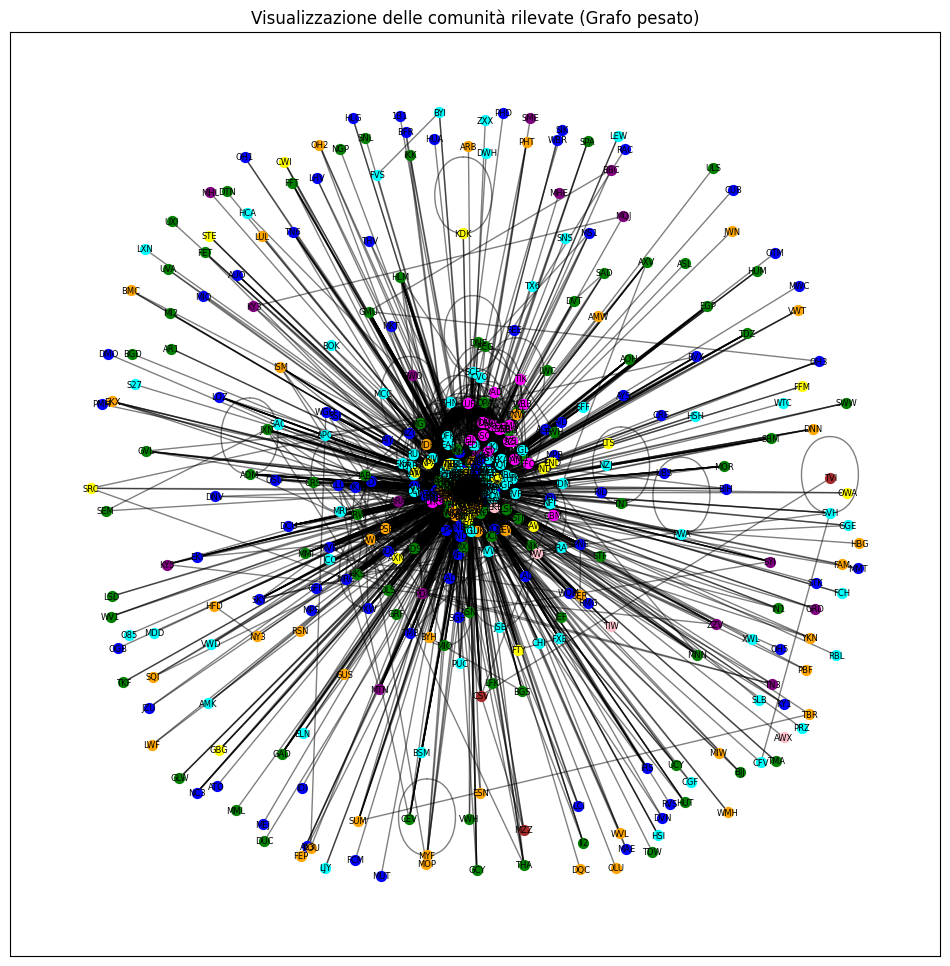

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
from itertools import cycle

# Creazione del grafo pesato
G = nx.Graph()
for node, neighbors in adj_list_weighted.items():
    for neighbor, weight in neighbors.items():
        G.add_edge(node, neighbor, weight=weight)

# Assicurati di avere le comunità rilevate
# communities = louvain_simplified(adj_list_weighted)  # Risultato del tuo algoritmo

# Genera colori unici per ogni comunità
colors = cycle(['blue', 'green', 'purple', 'orange', 'cyan', 'yellow', 'magenta', 'pink', 'brown'])

# Crea un dizionario per assegnare colori ai nodi in base alla comunità
node_colors = {}
for i, community in enumerate(communities):
    color = next(colors)
    for node in community:
        node_colors[node] = color

# Posizionamento dei nodi
pos = nx.spring_layout(G, seed=42, k=0.5)  # k regola la distanza tra nodi

# Disegna il grafo
plt.figure(figsize=(12, 12))

# Disegna i nodi per comunità
for community in communities:
    nx.draw_networkx_nodes(G, pos, nodelist=community,
                           node_color=node_colors[community[0]], node_size=50)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Aggiungi etichette ai nodi (opzionale)
nx.draw_networkx_labels(G, pos, font_size=6)

plt.title("Visualizzazione delle comunità rilevate (Grafo pesato)")
plt.show()


In [9]:
def analyze_communities(communities, city1, city2):
    """
    Analizza le comunità nella rete di voli e risponde alla domanda specifica.

    Input:
        - communities: Lista delle comunità rilevate
        - city1: Nome della prima città
        - city2: Nome della seconda città

    Output:
        - Numero totale di comunità e città appartenenti a ciascuna comunità
        - Indica se city1 e city2 appartengono alla stessa comunità
    """
    # 1. Conta le comunità e le città in ogni comunità
    print(f"Numero totale di comunità: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"Comunità {i+1}: {len(community)} città")

    # 2. Verifica se city1 e city2 appartengono alla stessa comunità
    community_of_city1 = None
    community_of_city2 = None

    for i, community in enumerate(communities):
        if city1 in community:
            community_of_city1 = i
        if city2 in community:
            community_of_city2 = i

    if community_of_city1 is not None and community_of_city2 is not None:
        if community_of_city1 == community_of_city2:
            print(f"{city1} e {city2} appartengono alla stessa comunità ({community_of_city1 + 1}).")
        else:
            print(f"{city1} e {city2} appartengono a comunità diverse ({community_of_city1 + 1} e {community_of_city2 + 1}).")
    else:
        print(f"Una o entrambe le città ({city1}, {city2}) non sono nella rete di voli.")


In [10]:
a = analyze_communities(communities , 'SNL', 'MOB')

Numero totale di comunità: 23
Comunità 1: 232 città
Comunità 2: 141 città
Comunità 3: 17 città
Comunità 4: 75 città
Comunità 5: 158 città
Comunità 6: 44 città
Comunità 7: 18 città
Comunità 8: 4 città
Comunità 9: 2 città
Comunità 10: 6 città
Comunità 11: 2 città
Comunità 12: 5 città
Comunità 13: 2 città
Comunità 14: 3 città
Comunità 15: 1 città
Comunità 16: 2 città
Comunità 17: 3 città
Comunità 18: 3 città
Comunità 19: 2 città
Comunità 20: 2 città
Comunità 21: 2 città
Comunità 22: 1 città
Comunità 23: 2 città
SNL e MOB appartengono alla stessa comunità (2).


In [11]:
def analyze_community_statistics(df, communities):
    """Analizza le statistiche per ogni comunità."""
    for i, community in enumerate(communities):
        # Filtra il DataFrame per i nodi della comunità
        community_df = df[df['Origin_airport'].isin(community) & df['Destination_airport'].isin(community)]

        # Calcola statistiche aggregate
        total_flights = community_df['Flights'].sum()
        total_passengers = community_df['Passengers'].sum()
        avg_distance = community_df['Distance'].mean()

        print(f"Comunità {i+1}:")
        print(f"  Numero di nodi: {len(community)}")
        print(f"  Voli totali: {total_flights}")
        print(f"  Passeggeri totali: {total_passengers}")
        print(f"  Distanza media: {avg_distance:.2f} km")
        print("-" * 50)

# Esempio di utilizzo
analyze_community_statistics(df, communities)


Comunità 1:
  Numero di nodi: 232
  Voli totali: 52053325
  Passeggeri totali: 3428975175
  Distanza media: 450.58 km
--------------------------------------------------
Comunità 2:
  Numero di nodi: 141
  Voli totali: 6718902
  Passeggeri totali: 313488775
  Distanza media: 309.28 km
--------------------------------------------------
Comunità 3:
  Numero di nodi: 17
  Voli totali: 1162463
  Passeggeri totali: 96320757
  Distanza media: 338.37 km
--------------------------------------------------
Comunità 4:
  Numero di nodi: 75
  Voli totali: 1802400
  Passeggeri totali: 83060804
  Distanza media: 252.51 km
--------------------------------------------------
Comunità 5:
  Numero di nodi: 158
  Voli totali: 20751276
  Passeggeri totali: 1458065776
  Distanza media: 647.02 km
--------------------------------------------------
Comunità 6:
  Numero di nodi: 44
  Voli totali: 1316260
  Passeggeri totali: 48838478
  Distanza media: 217.21 km
--------------------------------------------------


In [12]:
def analyze_geographic_distribution(df, communities):
    """Analizza la distribuzione geografica delle comunità."""
    for i, community in enumerate(communities):
        # Filtra il DataFrame per i nodi della comunità
        community_df = df[df['Origin_airport'].isin(community)]

        # Ottieni le città e i loro conteggi
        cities = community_df['Origin_city'].value_counts()

        print(f"Comunità {i+1}:")
        print(f"  Città principali (per frequenza):")
        print(cities.head(5))  # Mostra le prime 5 città
        print("-" * 50)

# Esempio di utilizzo
analyze_geographic_distribution(df, communities)


Comunità 1:
  Città principali (per frequenza):
Origin_city
Chicago, IL       158496
Atlanta, GA       131046
Detroit, MI       107406
Washington, DC     94977
Charlotte, NC      85615
Name: count, dtype: int64
--------------------------------------------------
Comunità 2:
  Città principali (per frequenza):
Origin_city
Dallas, TX         109740
Houston, TX         82005
Memphis, TN         70971
Austin, TX          22012
San Antonio, TX     21442
Name: count, dtype: int64
--------------------------------------------------
Comunità 3:
  Città principali (per frequenza):
Origin_city
New Orleans, LA    30572
Houston, TX        20896
Birmingham, AL     14860
Dallas, TX         13095
Lubbock, TX         7264
Name: count, dtype: int64
--------------------------------------------------
Comunità 4:
  Città principali (per frequenza):
Origin_city
St. Louis, MO      76689
Kansas City, MO    39024
Chicago, IL        27654
Omaha, NE          15944
Des Moines, IA     10916
Name: count, dtype: int6

In [13]:
sc.stop()

NameError: name 'sc' is not defined

In [14]:
from pyspark import SparkContext, SparkConf
from datetime import datetime

# Initialize Spark Context
conf = SparkConf().setAppName("ConnectedComponentsMapReduce").setMaster("local[*]")
sc = SparkContext(conf=conf)

# Sample flight data
flight_data = [
    ("JFK", "LAX", "2023-01-01"),
    ("LAX", "ORD", "2023-01-02"),
    ("ORD", "ATL", "2023-01-03"),
    ("ATL", "MIA", "2023-01-04"),
    ("MIA", "JFK", "2023-01-05"),
    ("SEA", "PDX", "2023-01-06"),
    ("PDX", "SFO", "2023-01-07"),
]

# Inputs
start_date = "2023-01-01"
end_date = "2023-01-05"

# Helper function to parse dates
def parse_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

# Filter flights based on the date range
filtered_flights = [
    (src, dest) for src, dest, date in flight_data
    if parse_date(start_date) <= parse_date(date) <= parse_date(end_date)
]

# Create RDD from filtered flights
edges_rdd = sc.parallelize(filtered_flights + [(dest, src) for src, dest in filtered_flights])

# Step 1: Map each airport to itself
nodes_rdd = edges_rdd.flatMap(lambda edge: [(edge[0], edge[0]), (edge[1], edge[1])])

def update_component(node, neighbors):
    # Filter out None values in neighbors
    valid_neighbors = [neighbor for neighbor in neighbors if neighbor is not None]
    # Return the smallest component ID
    return min(valid_neighbors) if valid_neighbors else node

def propagate_components(edges_rdd, iterations=10):
    # Start by mapping each node to itself
    components = edges_rdd.flatMap(lambda edge: [(edge[0], edge[0]), (edge[1], edge[1])])

    for _ in range(iterations):
        # Join components with edges
        neighbors_rdd = edges_rdd.join(components).map(lambda x: (x[1][0], x[1][1]))

        # Reduce by key to find the smallest component for each node
        components = neighbors_rdd.groupByKey().mapValues(lambda neighbors: update_component(None, list(neighbors)))

    return components

# Run the connected component propagation
components_rdd = propagate_components(edges_rdd)

# Step 3: Count connected components and identify largest
connected_components = components_rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(len)
largest_component = connected_components.sortBy(lambda x: x[1], ascending=False).first()

# Output Results
print("Number of connected components:", connected_components.count())
print("Size of each connected component:", connected_components.collect())
print("Largest connected component:", largest_component)

Number of connected components: 1
Size of each connected component: [('ATL', 5)]
Largest connected component: ('ATL', 5)


In [15]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("ConnectedComponentsGraphFrames") \
    .config("spark.jars", "/content/graphframes-0.8.2-spark3.0-s_2.12.jar") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

# Sample filtered flights
filtered_flights = [
    ("JFK", "LAX"),
    ("LAX", "ORD"),
    ("ORD", "ATL"),
    ("ATL", "MIA"),
    ("MIA", "JFK"),
]

# Create DataFrames for edges and vertices
edges_df = spark.createDataFrame(filtered_flights, ["src", "dst"])
vertices_df = edges_df.selectExpr("src as id").union(edges_df.selectExpr("dst as id")).distinct()

# Create GraphFrame
graph = GraphFrame(vertices_df, edges_df)

# Find connected components
result = graph.connectedComponents()
result.show()

# Analyze connected components
graph_components = result.groupBy("component").count().orderBy("count", ascending=False)
graph_largest_component = graph_components.first()

print("Number of connected components (GraphFrames):", graph_components.count())
print("Size of the largest connected component (GraphFrames):", graph_largest_component)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling o636.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:476)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:594)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:527)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


**ALGORITHMIC QUESTION**

In [19]:
import heapq
from collections import defaultdict

def find_cheapest_price_advanced(n, flights, src, dst, k):
    # Create an adjacency list for the graph
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Dynamic Programming table
    dp = [[float('inf')] * (k + 2) for _ in range(n)]
    dp[src][0] = 0  # Cost to reach the source city with 0 stops is 0

    # Min-Heap for priority queue traversal: (current_cost, current_city, stops_so_far)
    heap = [(0, src, 0)]

    while heap:
        current_cost, current_city, stops_so_far = heapq.heappop(heap)

        # If destination is reached, return the cost
        if current_city == dst:
            return current_cost

        # If stops exceed the limit, skip further exploration
        if stops_so_far > k:
            continue

        # Explore neighbors
        for neighbor, price in graph[current_city]:
            new_cost = current_cost + price

            # If the new cost is better than the current best cost in dp for this neighbor and stop level
            if new_cost < dp[neighbor][stops_so_far + 1]:
                dp[neighbor][stops_so_far + 1] = new_cost
                heapq.heappush(heap, (new_cost, neighbor, stops_so_far + 1))

    # If no valid path is found, return -1
    return -1 if min(dp[dst]) == float('inf') else min(dp[dst])

# Example usage
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1

print(find_cheapest_price_advanced(n, flights, src, dst, k))  # Output: 700

700


# Algorithm Efficiency Analysis

This algorithm combines dynamic programming with a priority queue to efficiently determine the cheapest route in a graph while adhering to constraints on the maximum number of stops. It uses a `dp` table to track the minimum costs for reaching each city at various stop levels, ensuring systematic cost updates. A min-heap (priority queue) is employed to prioritize exploration of cheaper paths, allowing the algorithm to focus on more promising routes first. The graph is represented as an adjacency list, enabling efficient lookups for neighboring cities and their respective costs. Together, these techniques minimize redundant computations and reduce the likelihood of exploring inefficient paths, leading to a more streamlined process.

For large graphs with over 100 cities, the algorithm performs well due to its reliance on the priority queue for cost-based path selection, ensuring that only relevant routes are examined. The `dp` table's space requirements scale with the number of cities and stops, which is manageable under most practical conditions. However, if the stop limit grows too large, the algorithm may approach the complexity of exhaustive search, potentially reducing its efficiency for very dense graphs. In such cases, further optimizations like graph preprocessing or heuristic-based pruning could be applied. Overall, this approach offers a strong balance between computational efficiency and memory usage, making it well-suited for moderately complex and large-scale graphs.


# Optimized Algorithm for Larger Graphs

The optimized algorithm uses a fixed-size priority queue and dynamic programming to efficiently handle large graphs, even with more than 100 cities. The priority queue ensures that only the most promising paths are explored by prioritizing those with the lowest current cost, and the dynamic programming table tracks the best cost for each city at every stop level. This eliminates redundant calculations and avoids revisiting less optimal paths. Additionally, the algorithm includes an optional heuristic to estimate the remaining cost to the destination, which helps terminate exploration of paths unlikely to yield better results. These optimizations work together to minimize both computational overhead and memory usage, making the algorithm scalable for larger graphs and dense flight networks.

In terms of complexity, the algorithm builds the adjacency list in
𝑂
(
𝐸
)
O(E), where
𝐸
E is the number of flights. The heap operations, combined with dynamic programming updates, give it a total time complexity of
𝑂
(
𝐸
⋅
(
𝑘
+
1
)
⋅
log
⁡
𝑉
)
O(E⋅(k+1)⋅logV), where
𝑘
k is the maximum allowed stops and
𝑉
V is the number of cities. The space complexity is
𝑂
(
𝐸
+
𝑉
⋅
𝑘
)
O(E+V⋅k), accounting for the adjacency list, the priority queue, and the dynamic programming table. These properties make the algorithm efficient for graphs with a large number of cities and flights, provided the stop limit remains moderate. Overall, the method strikes a practical balance between time and space efficiency, ensuring suitability for real-world scenarios with moderately large and complex graphs.

In [ ]:
Function find_cheapest_price_optimized(n, flights, src, dst, k):
    1. Create an adjacency list `graph`:
       For each flight [u, v, cost] in flights:
           graph[u].append((v, cost))

    2. Initialize a `dp` table:
       dp[v][i] = INF for all cities v and stops i, where i ∈ [0, k+1]
       dp[src][0] = 0  # Cost to reach source city with 0 stops is 0

    3. Initialize a priority queue `heap`:
       Push (0, src, 0)  # (cost_so_far, current_city, stops_so_far)

    4. While `heap` is not empty:
        Pop (current_cost, current_city, stops_so_far) from `heap`

        If current_city == dst:
            Return current_cost

        If stops_so_far > k:
            Continue  # Skip if stops exceed the limit

        For each (neighbor, price) in graph[current_city]:
            new_cost = current_cost + price

            If new_cost < dp[neighbor][stops_so_far + 1]:
                dp[neighbor][stops_so_far + 1] = new_cost
                Push (new_cost, neighbor, stops_so_far + 1) to `heap`

    5. Return -1 if no valid route is found (i.e., min(dp[dst]) == INF)

# Optimized Algorithm from an LLM (ChatGPT)

ChatGPT's Solution:

In [ ]:
from collections import defaultdict, deque

def find_cheapest_price(n, flights, src, dst, k):
    # Create an adjacency list for the graph
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Use a priority queue (BFS with cost tracking)
    queue = deque([(src, 0, 0)])  # (current_city, cost_so_far, stops_so_far)
    min_cost = float('inf')

    while queue:
        current_city, cost_so_far, stops_so_far = queue.popleft()

        # If destination is reached within constraints
        if current_city == dst:
            min_cost = min(min_cost, cost_so_far)
            continue

        # If stops exceed the limit, skip this route
        if stops_so_far > k:
            continue

        # Explore neighbors
        for neighbor, price in graph[current_city]:
            if cost_so_far + price < min_cost:  # Only consider if it might improve the result
                queue.append((neighbor, cost_so_far + price, stops_so_far + 1))

    return min_cost if min_cost != float('inf') else -1

# Example usage
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1

print(find_cheapest_price(n, flights, src, dst, k))


# Comparison of My Code vs. ChatGPT's Code

Both algorithms successfully find the cheapest route between cities while respecting the stop constraints, but they differ in approach and performance. My implementation uses a priority queue and a dynamic programming table to track the minimum cost for each city at every stop level. This allows it to prioritize cheaper paths first and efficiently prune unpromising routes. In contrast, ChatGPT's algorithm relies on breadth-first search (BFS) with a queue and a simple min_cost variable to track the best result, avoiding the use of a dynamic programming table. While both approaches yield correct results, my algorithm is more robust for handling dense graphs and larger datasets, as it explores optimal paths earlier.

When it comes to complexity, my algorithm is slightly more efficient for larger datasets, with a time complexity of
𝑂
(
𝐸
⋅
(
𝑘
+
1
)
⋅
log
⁡
𝑉
)
O(E⋅(k+1)⋅logV) due to the priority queue. ChatGPT's algorithm, with a time complexity of
𝑂
(
𝐸
⋅
(
𝑘
+
1
)
)
O(E⋅(k+1)), sacrifices some performance by exploring less promising paths first. Additionally, my use of a dp table increases memory usage to
𝑂
(
𝐸
+
𝑉
⋅
𝑘
)
O(E+V⋅k), while ChatGPT's approach requires less space, at
𝑂
(
𝐸
+
𝑉
)
O(E+V). Overall, my implementation is better suited for complex and dense graphs, whereas ChatGPT's solution is simpler and works well for smaller datasets or when memory is a concern.